# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.75KFile/s] 


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

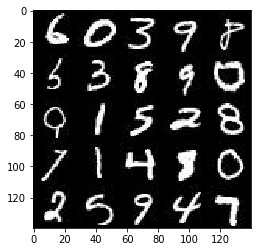

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

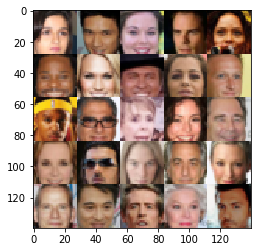

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    image_tensor = tf.placeholder(dtype=tf.float32, shape=(None, image_height, image_width, image_channels), name='input_real')
    z_data_tensor = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name='input_z')
    learning_rate_tensor = tf.placeholder(dtype=tf.float32, shape=None)

    return image_tensor, z_data_tensor, learning_rate_tensor


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    current_filter = 64
    kernel_size = 5
    strides = 2
    padding = 'same'
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # layer 1
        x1 = tf.layers.conv2d(images, current_filter, kernel_size, strides=strides, padding=padding)
        x1 = tf.maximum(alpha * x1, x1)
        
        # layer 2
        current_filter = current_filter * 2
        x2 = tf.layers.conv2d(x1, current_filter, kernel_size, strides=strides, padding=padding)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        # layer 3
        current_filter = current_filter * 2
        x3 = tf.layers.conv2d(x2, current_filter, kernel_size, strides=strides, padding=padding)
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        
        flatten = tf.reshape(x3, (-1, 4 * 4 * current_filter))
        logits = tf.layers.dense(flatten, 1)
        output = tf.sigmoid(logits)
        
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    high = 3
    width = 3
    filters = 512
    kernel_size = 3
    strides = 2
    
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        x1 = tf.layers.dense(z, high * width * filters)
        
        # tensor size = image ( 3x3x512 )  (high x width x filters)
        x1 = tf.reshape(x1, (-1, high, width, filters))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        # tensor size = image ( 7x7x256 )
        filters = filters // 2
        x2 = tf.layers.conv2d_transpose(x1, filters, kernel_size, strides=strides, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        # tensor size = image ( 14x14x128 )
        filters = filters // 2
        x3 = tf.layers.conv2d_transpose(x2, filters, kernel_size, strides=strides, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # tensor size = image ( 28 x 28 x out_channel_dim )
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, kernel_size, strides=strides, padding='same')
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, True)
    d_real_out, d_real_logits = discriminator(input_real)
    d_fake_out, d_fake_logits = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=tf.ones_like(d_real_out)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.zeros_like(d_fake_out)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.ones_like(d_fake_out)))
    
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_var = tf.trainable_variables()
    d_var = [var for var in t_var if var.name.startswith('discriminator')]
    g_var = [var for var in t_var if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_var)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_var)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    every_print_step = 25
    every_show_step = 100
    n_images_to_show = 25
    
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
        
    step = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                step += 1

                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # scaling real images to be btween -1 and 1 like the generator output
                batch_images = batch_images * 2
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})

                if step % every_print_step == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if step % every_show_step == 0:
                    show_generator_output(sess, n_images_to_show, input_z, image_channels, data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9819... Generator Loss: 10.2402
Epoch 1/2... Discriminator Loss: 0.7777... Generator Loss: 1.6101
Epoch 1/2... Discriminator Loss: 1.6196... Generator Loss: 0.3153
Epoch 1/2... Discriminator Loss: 0.5304... Generator Loss: 2.0862


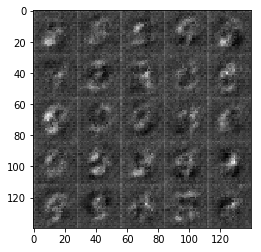

Epoch 1/2... Discriminator Loss: 0.5663... Generator Loss: 2.6240
Epoch 1/2... Discriminator Loss: 1.1570... Generator Loss: 0.4701
Epoch 1/2... Discriminator Loss: 1.2147... Generator Loss: 0.4197
Epoch 1/2... Discriminator Loss: 1.3780... Generator Loss: 4.2959


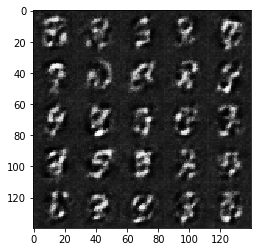

Epoch 1/2... Discriminator Loss: 0.5353... Generator Loss: 1.1303
Epoch 1/2... Discriminator Loss: 0.8808... Generator Loss: 3.5704
Epoch 1/2... Discriminator Loss: 0.3910... Generator Loss: 1.5586
Epoch 1/2... Discriminator Loss: 0.5125... Generator Loss: 1.1546


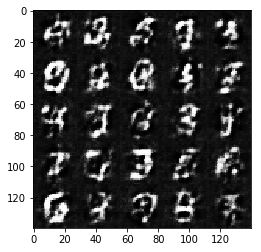

Epoch 1/2... Discriminator Loss: 1.2780... Generator Loss: 0.5265
Epoch 1/2... Discriminator Loss: 0.3696... Generator Loss: 2.4154
Epoch 1/2... Discriminator Loss: 0.7488... Generator Loss: 0.8485
Epoch 1/2... Discriminator Loss: 0.4217... Generator Loss: 1.5214


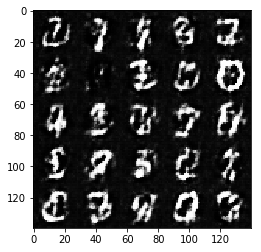

Epoch 1/2... Discriminator Loss: 0.8257... Generator Loss: 0.8584
Epoch 1/2... Discriminator Loss: 0.5047... Generator Loss: 1.3032
Epoch 1/2... Discriminator Loss: 0.4692... Generator Loss: 1.5556
Epoch 1/2... Discriminator Loss: 0.5343... Generator Loss: 1.1658


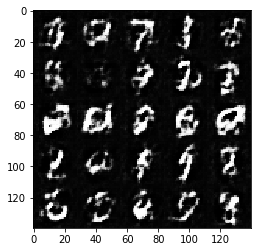

Epoch 1/2... Discriminator Loss: 0.4277... Generator Loss: 1.3777
Epoch 1/2... Discriminator Loss: 0.5727... Generator Loss: 1.1824
Epoch 1/2... Discriminator Loss: 0.4390... Generator Loss: 2.0801
Epoch 1/2... Discriminator Loss: 0.5294... Generator Loss: 1.1617


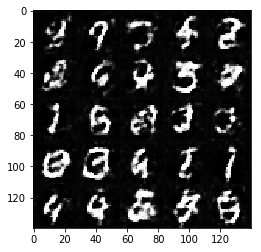

Epoch 1/2... Discriminator Loss: 0.8745... Generator Loss: 0.6527
Epoch 1/2... Discriminator Loss: 0.6327... Generator Loss: 1.1477
Epoch 1/2... Discriminator Loss: 0.7382... Generator Loss: 0.8164
Epoch 1/2... Discriminator Loss: 0.5828... Generator Loss: 1.1402


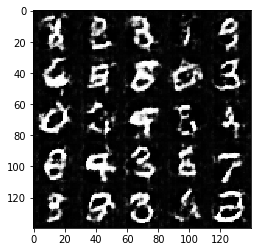

Epoch 1/2... Discriminator Loss: 0.6319... Generator Loss: 1.4806
Epoch 1/2... Discriminator Loss: 0.5745... Generator Loss: 2.7586
Epoch 1/2... Discriminator Loss: 0.5788... Generator Loss: 1.2350
Epoch 1/2... Discriminator Loss: 0.6576... Generator Loss: 2.6666


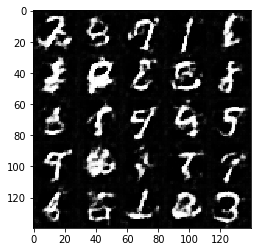

Epoch 1/2... Discriminator Loss: 0.5602... Generator Loss: 1.1914
Epoch 1/2... Discriminator Loss: 0.8683... Generator Loss: 0.7688
Epoch 1/2... Discriminator Loss: 0.5777... Generator Loss: 1.1034
Epoch 1/2... Discriminator Loss: 0.9200... Generator Loss: 0.6917


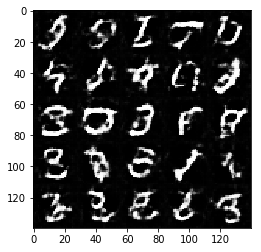

Epoch 1/2... Discriminator Loss: 0.6692... Generator Loss: 0.9694
Epoch 2/2... Discriminator Loss: 0.8446... Generator Loss: 0.7679
Epoch 2/2... Discriminator Loss: 0.7223... Generator Loss: 0.8339
Epoch 2/2... Discriminator Loss: 0.6124... Generator Loss: 1.1892


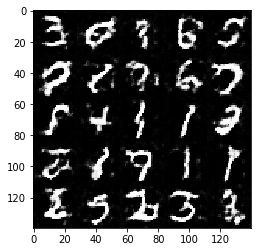

Epoch 2/2... Discriminator Loss: 0.6024... Generator Loss: 1.2209
Epoch 2/2... Discriminator Loss: 1.0190... Generator Loss: 0.5714
Epoch 2/2... Discriminator Loss: 1.5865... Generator Loss: 0.3369
Epoch 2/2... Discriminator Loss: 0.3855... Generator Loss: 1.9263


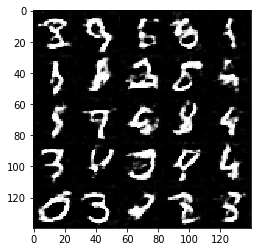

Epoch 2/2... Discriminator Loss: 1.0883... Generator Loss: 2.3439
Epoch 2/2... Discriminator Loss: 0.6783... Generator Loss: 1.0544
Epoch 2/2... Discriminator Loss: 0.5722... Generator Loss: 2.0201
Epoch 2/2... Discriminator Loss: 0.4708... Generator Loss: 1.4909


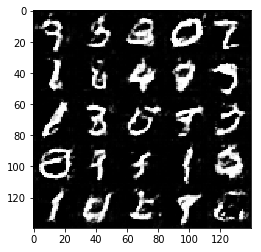

Epoch 2/2... Discriminator Loss: 0.5148... Generator Loss: 1.3143
Epoch 2/2... Discriminator Loss: 0.7763... Generator Loss: 0.8212
Epoch 2/2... Discriminator Loss: 0.8812... Generator Loss: 0.7069
Epoch 2/2... Discriminator Loss: 0.6472... Generator Loss: 1.0223


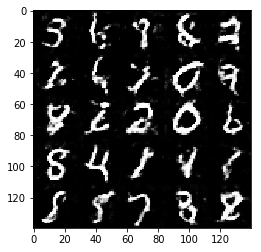

Epoch 2/2... Discriminator Loss: 2.2422... Generator Loss: 0.2142
Epoch 2/2... Discriminator Loss: 0.6438... Generator Loss: 1.0550
Epoch 2/2... Discriminator Loss: 0.6797... Generator Loss: 0.9698
Epoch 2/2... Discriminator Loss: 0.5863... Generator Loss: 1.1820


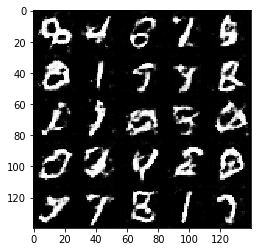

Epoch 2/2... Discriminator Loss: 0.5946... Generator Loss: 1.2741
Epoch 2/2... Discriminator Loss: 0.7088... Generator Loss: 0.9223
Epoch 2/2... Discriminator Loss: 0.5634... Generator Loss: 1.1313
Epoch 2/2... Discriminator Loss: 0.7042... Generator Loss: 0.9286


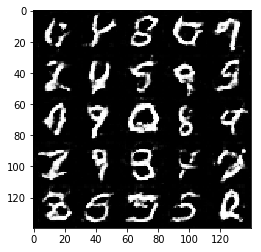

Epoch 2/2... Discriminator Loss: 0.7594... Generator Loss: 0.8530
Epoch 2/2... Discriminator Loss: 0.7886... Generator Loss: 0.8262
Epoch 2/2... Discriminator Loss: 0.7211... Generator Loss: 0.8938
Epoch 2/2... Discriminator Loss: 0.5542... Generator Loss: 1.6717


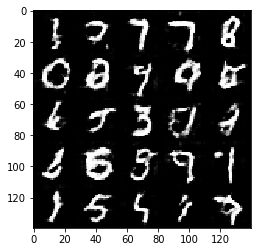

Epoch 2/2... Discriminator Loss: 1.0867... Generator Loss: 0.5493
Epoch 2/2... Discriminator Loss: 0.6319... Generator Loss: 1.0559
Epoch 2/2... Discriminator Loss: 0.6442... Generator Loss: 1.2743
Epoch 2/2... Discriminator Loss: 0.8308... Generator Loss: 0.8062


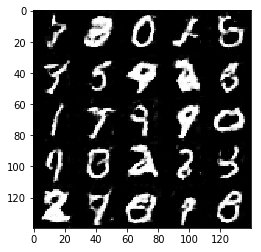

Epoch 2/2... Discriminator Loss: 1.1477... Generator Loss: 0.4669
Epoch 2/2... Discriminator Loss: 1.0336... Generator Loss: 0.6369
Epoch 2/2... Discriminator Loss: 0.7799... Generator Loss: 0.8312
Epoch 2/2... Discriminator Loss: 0.6165... Generator Loss: 1.0836


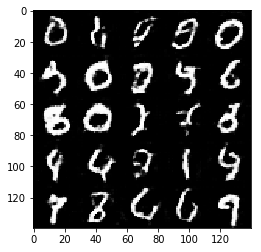

Epoch 2/2... Discriminator Loss: 1.1325... Generator Loss: 0.5122
Epoch 2/2... Discriminator Loss: 0.6708... Generator Loss: 1.6450


In [14]:
batch_size = 64
z_dim = 125
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.7527... Generator Loss: 7.2665
Epoch 1/1... Discriminator Loss: 1.8683... Generator Loss: 0.2198
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 1.2654
Epoch 1/1... Discriminator Loss: 1.5461... Generator Loss: 0.3522


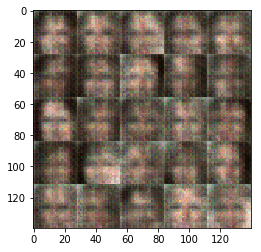

Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 0.6372
Epoch 1/1... Discriminator Loss: 1.7156... Generator Loss: 2.1808
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.3699
Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 0.3285


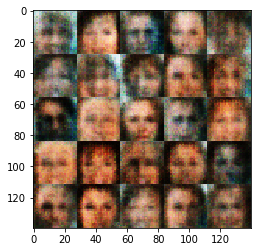

Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 0.8568
Epoch 1/1... Discriminator Loss: 1.5078... Generator Loss: 2.0239
Epoch 1/1... Discriminator Loss: 0.7693... Generator Loss: 1.1809
Epoch 1/1... Discriminator Loss: 0.8399... Generator Loss: 0.8662


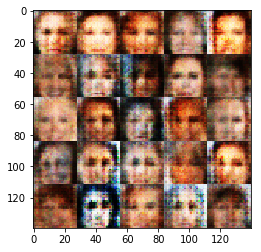

Epoch 1/1... Discriminator Loss: 0.7919... Generator Loss: 1.0711
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.4127
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.3657
Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 1.1909


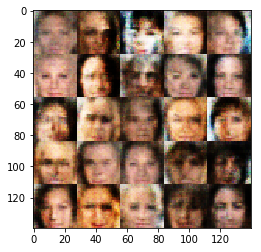

Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.6103
Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 1.3894
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.5518


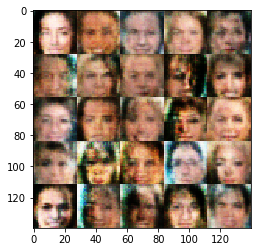

Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 1.2941
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.4580
Epoch 1/1... Discriminator Loss: 1.5342... Generator Loss: 0.3231
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 0.8802


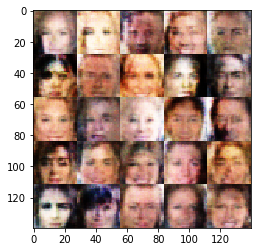

Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 1.0043
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 1.1410
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.4252
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 1.3310


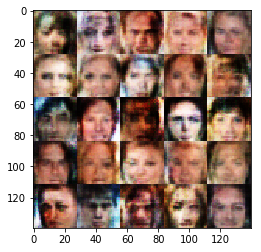

Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.4348
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.4514
Epoch 1/1... Discriminator Loss: 1.0514... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 2.0606... Generator Loss: 0.1763


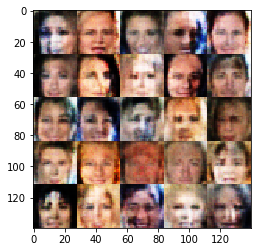

Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 1.8586
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.3950
Epoch 1/1... Discriminator Loss: 1.8125... Generator Loss: 0.2115
Epoch 1/1... Discriminator Loss: 0.6251... Generator Loss: 2.1220


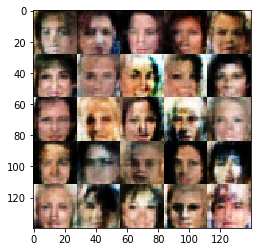

Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.3764
Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 1.7628
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 0.4422
Epoch 1/1... Discriminator Loss: 0.9114... Generator Loss: 2.1087


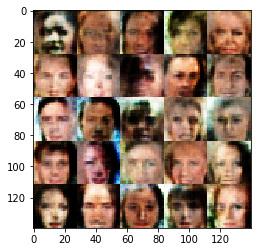

Epoch 1/1... Discriminator Loss: 0.8076... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 1.7731
Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 2.4749
Epoch 1/1... Discriminator Loss: 0.7328... Generator Loss: 1.5869


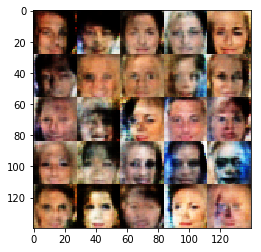

Epoch 1/1... Discriminator Loss: 1.1107... Generator Loss: 0.5298
Epoch 1/1... Discriminator Loss: 1.7013... Generator Loss: 0.2458
Epoch 1/1... Discriminator Loss: 0.7724... Generator Loss: 1.7697
Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 0.5189


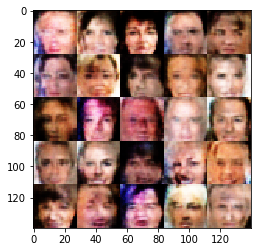

Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 2.5367
Epoch 1/1... Discriminator Loss: 1.7074... Generator Loss: 0.2426
Epoch 1/1... Discriminator Loss: 0.7766... Generator Loss: 1.9887
Epoch 1/1... Discriminator Loss: 0.7809... Generator Loss: 0.8573


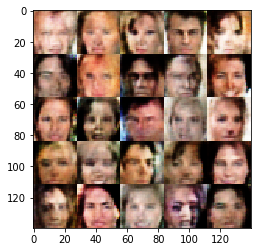

Epoch 1/1... Discriminator Loss: 0.6554... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 0.6740... Generator Loss: 2.0442
Epoch 1/1... Discriminator Loss: 0.3796... Generator Loss: 1.9012
Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 0.4382


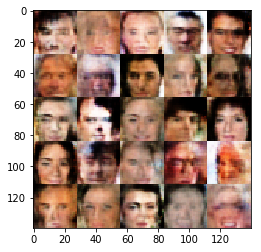

Epoch 1/1... Discriminator Loss: 0.4208... Generator Loss: 2.8163
Epoch 1/1... Discriminator Loss: 0.5618... Generator Loss: 1.0913
Epoch 1/1... Discriminator Loss: 0.6929... Generator Loss: 0.8949
Epoch 1/1... Discriminator Loss: 1.1464... Generator Loss: 1.1193


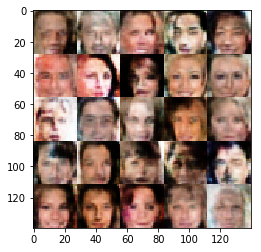

Epoch 1/1... Discriminator Loss: 0.8508... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 0.5595... Generator Loss: 2.8980
Epoch 1/1... Discriminator Loss: 0.7977... Generator Loss: 2.4951
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 1.0348


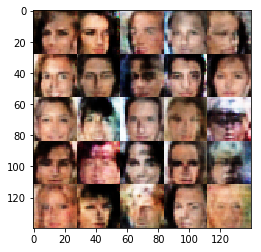

Epoch 1/1... Discriminator Loss: 1.7288... Generator Loss: 0.2554
Epoch 1/1... Discriminator Loss: 0.3056... Generator Loss: 1.9720
Epoch 1/1... Discriminator Loss: 1.7424... Generator Loss: 0.2408
Epoch 1/1... Discriminator Loss: 1.6794... Generator Loss: 0.2628


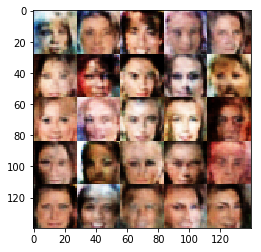

Epoch 1/1... Discriminator Loss: 0.9757... Generator Loss: 0.5931
Epoch 1/1... Discriminator Loss: 0.7916... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 0.8368... Generator Loss: 0.8446
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.3663


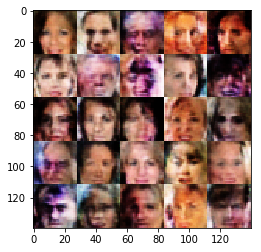

Epoch 1/1... Discriminator Loss: 0.7513... Generator Loss: 1.2638
Epoch 1/1... Discriminator Loss: 0.9825... Generator Loss: 0.8645
Epoch 1/1... Discriminator Loss: 0.9170... Generator Loss: 2.6540
Epoch 1/1... Discriminator Loss: 0.5382... Generator Loss: 1.3326


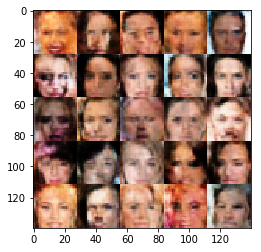

Epoch 1/1... Discriminator Loss: 0.4491... Generator Loss: 2.0809
Epoch 1/1... Discriminator Loss: 1.7807... Generator Loss: 0.2423
Epoch 1/1... Discriminator Loss: 0.8729... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 0.4182... Generator Loss: 2.0375


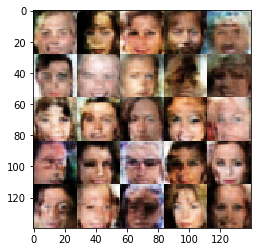

Epoch 1/1... Discriminator Loss: 1.5687... Generator Loss: 0.3013
Epoch 1/1... Discriminator Loss: 2.1656... Generator Loss: 0.1571
Epoch 1/1... Discriminator Loss: 0.4152... Generator Loss: 1.6582
Epoch 1/1... Discriminator Loss: 1.7805... Generator Loss: 0.2374


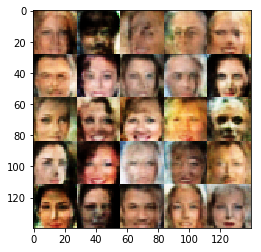

Epoch 1/1... Discriminator Loss: 0.5519... Generator Loss: 2.0170
Epoch 1/1... Discriminator Loss: 0.4926... Generator Loss: 1.8040
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 0.4303
Epoch 1/1... Discriminator Loss: 1.6463... Generator Loss: 0.2611


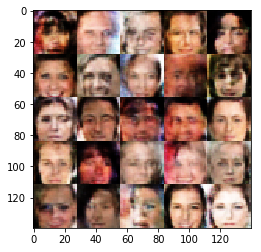

Epoch 1/1... Discriminator Loss: 1.5787... Generator Loss: 0.2936
Epoch 1/1... Discriminator Loss: 0.4897... Generator Loss: 2.2118
Epoch 1/1... Discriminator Loss: 0.8052... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.0721... Generator Loss: 0.7651


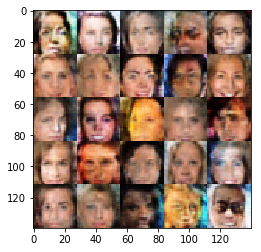

Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 0.4852
Epoch 1/1... Discriminator Loss: 0.6975... Generator Loss: 0.9550
Epoch 1/1... Discriminator Loss: 0.5352... Generator Loss: 1.1303
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 1.7729


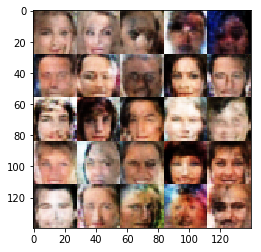

Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.5017... Generator Loss: 0.3040
Epoch 1/1... Discriminator Loss: 0.6225... Generator Loss: 1.3339
Epoch 1/1... Discriminator Loss: 0.5282... Generator Loss: 1.2306


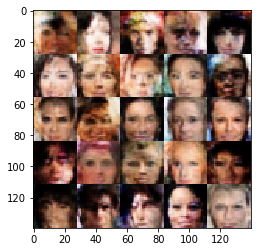

Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 2.2120
Epoch 1/1... Discriminator Loss: 0.5471... Generator Loss: 1.6767
Epoch 1/1... Discriminator Loss: 0.7042... Generator Loss: 0.9079
Epoch 1/1... Discriminator Loss: 0.8466... Generator Loss: 0.6939


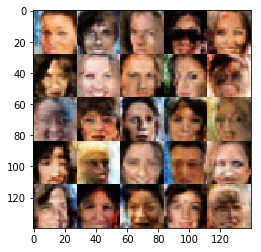

Epoch 1/1... Discriminator Loss: 1.9745... Generator Loss: 2.9105
Epoch 1/1... Discriminator Loss: 0.6091... Generator Loss: 1.0657
Epoch 1/1... Discriminator Loss: 1.6079... Generator Loss: 0.2930
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.3949


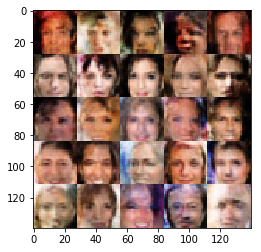

Epoch 1/1... Discriminator Loss: 0.6217... Generator Loss: 2.0764
Epoch 1/1... Discriminator Loss: 0.7203... Generator Loss: 0.8839
Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 1.6391
Epoch 1/1... Discriminator Loss: 0.5949... Generator Loss: 1.1139


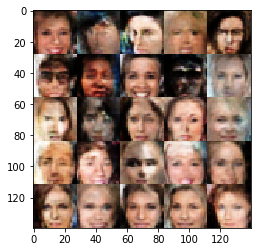

Epoch 1/1... Discriminator Loss: 3.1869... Generator Loss: 4.2274
Epoch 1/1... Discriminator Loss: 1.9701... Generator Loss: 0.1863
Epoch 1/1... Discriminator Loss: 0.4153... Generator Loss: 1.7339
Epoch 1/1... Discriminator Loss: 0.6618... Generator Loss: 0.9168


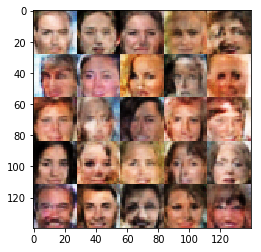

Epoch 1/1... Discriminator Loss: 0.4081... Generator Loss: 1.5656
Epoch 1/1... Discriminator Loss: 0.9088... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 0.6141... Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: 1.0932... Generator Loss: 1.7765


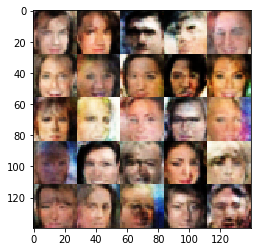

Epoch 1/1... Discriminator Loss: 1.6369... Generator Loss: 3.2965
Epoch 1/1... Discriminator Loss: 0.7304... Generator Loss: 1.3270
Epoch 1/1... Discriminator Loss: 0.4929... Generator Loss: 2.7136
Epoch 1/1... Discriminator Loss: 0.4135... Generator Loss: 1.3876


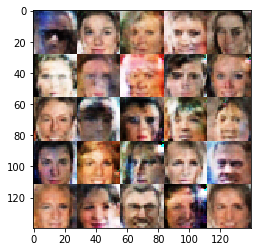

Epoch 1/1... Discriminator Loss: 0.4648... Generator Loss: 1.4896
Epoch 1/1... Discriminator Loss: 0.4428... Generator Loss: 2.1724


In [16]:
batch_size = 64
z_dim = 150
learning_rate = 0.0004
beta1 = 0.15


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.